In [ ]:
# импортируйте нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
# сгенерируйте линейно разделимую выборку для задачи бинарной классификации

np.random.seed(0)
num_samples = 1000
# X = np.random.randn(num_samples, 2)
# y = (X[:, 0] + X[:, 1] > 0).astype(int)
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1.5, random_state=42)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

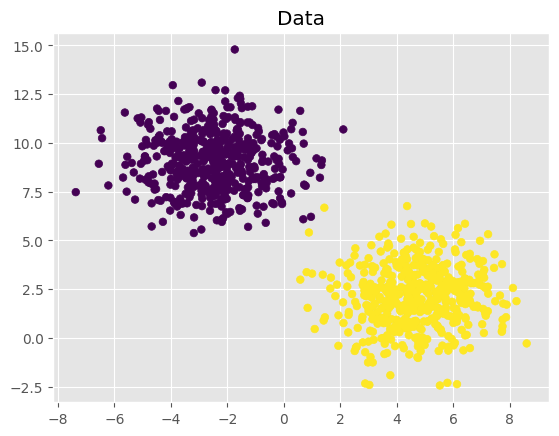

In [ ]:
# Plot data points
plt.style.use("ggplot")
plt.figure()
plt.title("Data")
plt.scatter(X[:, 0], X[:,1], marker="o", c=np.squeeze(y), s=30);

# Логистическая регрессия

Конечным результатом задачи классификации является разбиение множества объектов на классы. Давайте усложним задачу и будем предсказывать не конкретные классы, а вероятности принадлежать им, например, для бинарной классификации мы будем предсказывать одно число, которое будет соответствовать вероятности принадлежать положительному классу. \
Такого результата можно достичь, если мы будем строить линейную регрессию над некоторыми признаками, а затем её результат переводить в отрезок $[0;1]$. В этом нам поможет сигмоидная функция, которая имеет вид:
<p style="text-align: center;"> $f(z) = \dfrac{1}{1 + e^{-z}}$ </p>

![sigmoid.webp](https://cmertin.github.io/images/2016/11/11_17-Loan_Approvals/Sigmoid_Function.png)
<p style="text-align: center;"></p>

Моделью логистической регрессии назовём функцию от весов и объекта вида:

<p style="text-align: center;"> $a(w, x) = \dfrac{1}{1 + e^{-w_0 - w_1x_1 + ... + w_mx_m}}$ </p>

Обучение данной модели происходит за счет кросс-энтропийной или логистическая функции потерь :
<p style="text-align: center;"> $-\sum\limits_{i=1}^{n}(y_ilog(a_i) + (1 - y_i)log(1 - a_i))$ </p>
где $a_i = a(w, x_i)$

#### Задание №1. Выведите шаг градиентного спуска для логистической функции потерь (приложить фото)

Предсказание модели для логистической регрессии вычесляется как:
$$p=\frac{1}{1 + e^{-\langle w, x_i\rangle}} = \sigma(\langle w, x_i\rangle)$$

функция ошибки:
$$L(w, X, y) = -\sum_i \big( y_i \log(\sigma(\langle w, x_i \rangle)) + (1 - y_i) \log(\sigma(-\langle w, x_i \rangle)) \big)$$

шаг градиентного спуска (с точностью до нормировки):

$$\boxed{\nabla_w L(y, X, w) = -\sum_{i=0}^{m} x_i \big( y_i - \sigma(\langle w, x_i \rangle)) \big)}$$

Вывод формулы выше можно легко сделать, если заметить, что:

$$
\sigma(-z) = \frac{1}{1 + e^z} = \frac{e^{-z}}{e^{-z} + 1} = 1 - \sigma(z),
$$

$$
\frac{d \log \sigma(-z)}{d z} = -\sigma(z)
$$

$$
\nabla_w \log \sigma(-\langle w, x_i \rangle) =  -\sigma(\langle w, x_i \rangle) x_i
$$

Поэтому градиент функции потерь можно записать как:

$$
\nabla_w L(y, X, w) = -\sum_i \big( y_i x_i \sigma(-\langle w, x_i \rangle) - (1 - y_i) x_i \sigma(\langle w, x_i \rangle)) \big) = \
$$
$$
= -\sum_i \big( y_i x_i (1 - \sigma(\langle w, x_i \rangle)) - (1 - y_i) x_i \sigma(\langle w, x_i \rangle)) \big) = \
$$

$$
= -\sum_i \big( y_i x_i - y_i x_i \sigma(\langle w, x_i \rangle) - x_i \sigma(\langle w, x_i \rangle) + y_i x_i \sigma(\langle w, x_i \rangle)) \big) = \
$$

$$
= -\sum_i \big( y_i x_i - x_i \sigma(\langle w, x_i \rangle)) \big) = \
-\sum_i x_i\big( y_i - \sigma(\langle w, x_i \rangle)) \big)
$$

#### Задание №2. Напишите собственную логистическую регрессию

In [ ]:
class MyLogRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept

    def __add_intercept(self, X_):
        intercept = np.ones((X_.shape[0], 1))
        return np.concatenate((intercept, X_), axis=1)

    @staticmethod
    def __sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        self.theta = np.zeros(X.shape[1])

        for _ in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient


    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.theta))

    def predict(self, X, threshold=0.5):
        return self.predict_prob(X) >= threshold

#### Задание №3. Сравните свою логистическую регрессию с аналогичной моделью из sklearn на сгенерированном датасете, опираясь на Accuracy. Баллы за задание: 10 - Accuracy > 99, 5 - Accuracy > 85, 0 - иначе

In [ ]:
# Train the logistic regression model
model = MyLogRegression(lr=0.1, num_iter=100000)
model.fit(X_train, y_train)

# Predict and evaluate the accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


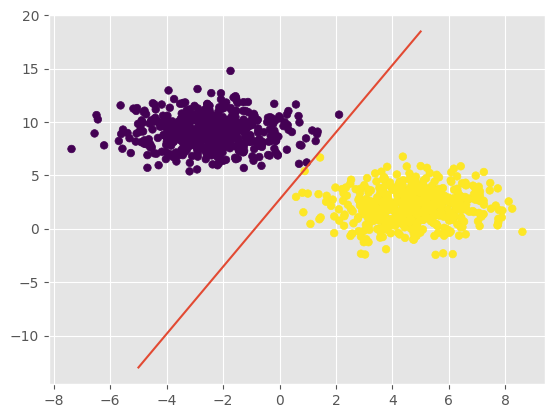

In [ ]:
# Let's construct a dividing line (hyperplane)
x = np.linspace(-5, 5, 100)
c = model.theta

plt.plot(x, -(c[0] + c[1] * x) / c[2])
plt.scatter(X[:, 0], X[:,1], marker="o", c=np.squeeze(y), s=30);

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")

Accuracy: 1.0
